In [538]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np

In [554]:
def plot_quantizer(x_plot, y_plot, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_label_coords(1,0.40)
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_coords(0.45,.9)
    ax.yaxis.set_label_text('Output')

    ticks = np.arange(-8, 9, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.grid()
    ax.plot(x_plot, y_plot)

In [942]:
def plot(x, y, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)

In [943]:
def print_center(x, y, z, n):
    offset = (len(x)-n)//2
    for i in range(n):
        input = int(x[i+offset])
        output = int(y[i+offset])
        recons = int(z[i+offset])
        print(f"{input:>6d} {output:>6d} {recons:>6d}")

# Scalar Quantization of Digital Signals

## A.  Uniform Quantization

### A.a. Midtread ("round") Quantization

In [944]:
def midtread_quantizer(x, quantization_step):
    return np.round(x / quantization_step)

In [945]:
def midtread_dequantizer(y, quantization_step):
    return y * quantization_step

#### A.a.1. No quantization ($\Delta=1$)

In [946]:
quantization_step = 1 # Delta

#### Quantizer

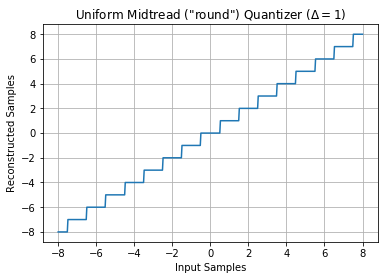

In [948]:
x = np.linspace(-8, 8, 500) # Input samples
y = midtread_quantizer(x, quantization_step) # Quantized samples
z = midtread_dequantizer(y, quantization_step) # Reconstructed samples
#plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

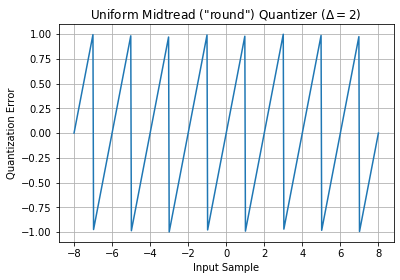

In [966]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [958]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step).astype(np.int16)
z = midtread_dequantizer(y, quantization_step)

In [961]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 16)

 Input Output Recons
    -8     -8     -8
    -7     -7     -7
    -6     -6     -6
    -5     -5     -5
    -4     -4     -4
    -3     -3     -3
    -2     -2     -2
    -1     -1     -1
     0      0      0
     1      1      1
     2      2      2
     3      3      3
     4      4      4
     5      5      5
     6      6      6
     7      7      7


In [962]:
len(np.unique(x, return_counts = True)[0])

65536

In [614]:
len(np.unique(y, return_counts = True)[0])

65536

Notice that for $\Delta=1$, the number of bits for representing the input and the output is the same. $65536$ different inputs are represented by $65536$ outputs.

#### A.a.2. Quantization with quantization step $\Delta=2$

In [964]:
quantization_step = 2 # Delta

#### Quantizer

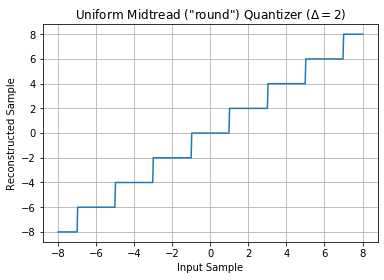

In [965]:
x = np.linspace(-8, 8, 500)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

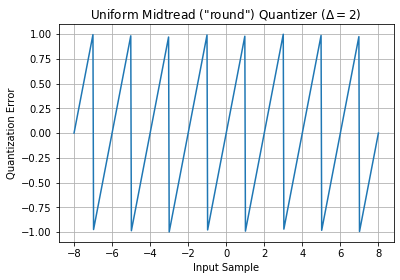

In [967]:
error_plot = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [968]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step).astype(np.int16)
z = midtread_dequantizer(y, quantization_step)

In [970]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 32)

 Input Output Recons
   -16     -8    -16
   -15     -8    -16
   -14     -7    -14
   -13     -6    -12
   -12     -6    -12
   -11     -6    -12
   -10     -5    -10
    -9     -4     -8
    -8     -4     -8
    -7     -4     -8
    -6     -3     -6
    -5     -2     -4
    -4     -2     -4
    -3     -2     -4
    -2     -1     -2
    -1      0      0
     0      0      0
     1      0      0
     2      1      2
     3      2      4
     4      2      4
     5      2      4
     6      3      6
     7      4      8
     8      4      8
     9      4      8
    10      5     10
    11      6     12
    12      6     12
    13      6     12
    14      7     14
    15      8     16


In [971]:
len(np.unique(y, return_counts = True)[0])

32769

For $\Delta=2$, a midtread uniform quantizer represents 65536 different inputs with 32769 outputs.

#### A.a.3. Quantization with quantization step $\Delta=3$

In [972]:
quantization_step = 3

#### Quantizer

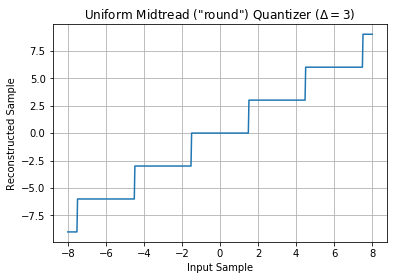

In [974]:
x = np.linspace(-8, 8, 500)
y = midtread_quantizer(x, quantization_step) # Quantized samples
z = midtread_dequantizer(y, quantization_step) # Reconstructed samples
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

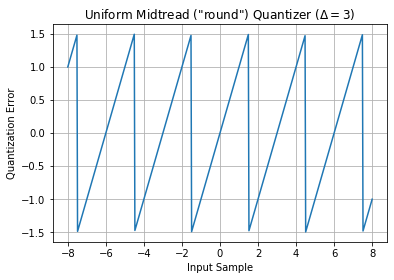

In [975]:
x_plot_recons = y_plot * quantization_step
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [976]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step).astype(np.int16)
z = midtread_dequantizer(y, quantization_step)

In [977]:
print_center(x, y, z, 32)

   -16     -5    -15
   -15     -5    -15
   -14     -5    -15
   -13     -4    -12
   -12     -4    -12
   -11     -4    -12
   -10     -3     -9
    -9     -3     -9
    -8     -3     -9
    -7     -2     -6
    -6     -2     -6
    -5     -2     -6
    -4     -1     -3
    -3     -1     -3
    -2     -1     -3
    -1      0      0
     0      0      0
     1      0      0
     2      1      3
     3      1      3
     4      1      3
     5      2      6
     6      2      6
     7      2      6
     8      3      9
     9      3      9
    10      3      9
    11      4     12
    12      4     12
    13      4     12
    14      5     15
    15      5     15


In [978]:
len(np.unique(y, return_counts = True)[0])

21846

For $\Delta=3$, a midtread uniform quantizer represents 65536 different inputs with 21846 outputs.

### A.a.4. Quantization with $\Delta=4$

In [979]:
quantization_step = 4 # Delta

#### Quantizer

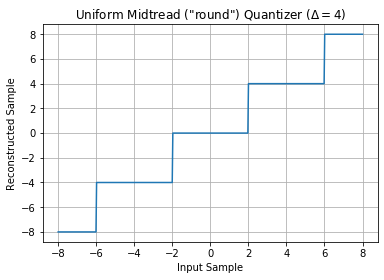

In [980]:
x = np.linspace(-8, 8, 500) # Input samples
y = midtread_quantizer(x, quantization_step) # Quantized samples
z = midtread_dequantizer(y, quantization_step) # Reconstructed samples
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

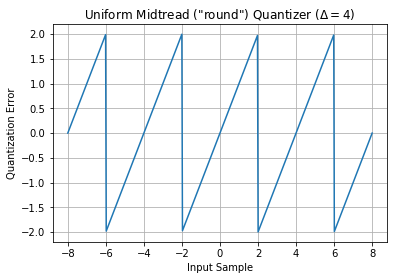

In [981]:
x_plot_recons = y_plot * quantization_step
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [983]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step).astype(np.int16)
z = midtread_dequantizer(y, quantization_step)

In [984]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 16)

 Input Output Recons
    -8     -2     -8
    -7     -2     -8
    -6     -2     -8
    -5     -1     -4
    -4     -1     -4
    -3     -1     -4
    -2      0      0
    -1      0      0
     0      0      0
     1      0      0
     2      0      0
     3      1      4
     4      1      4
     5      1      4
     6      2      8
     7      2      8


In [985]:
len(np.unique(y, return_counts = True)[0])

16385

For $\Delta=1$, $65536$ different values are represented by $16385$ values.

### A.b. Deadzone ("truncation") Quantization

In [642]:
def deadzone_quantizer(x, quantization_step):
    return (x / quantization_step)

In [643]:
def deadzone_dequantizer(y, quantization_step):
    return y * quantization_step

#### A.b.1. Quantization with $\Delta=2$

In [644]:
quantization_step = 2 # Delta

#### Quantizer

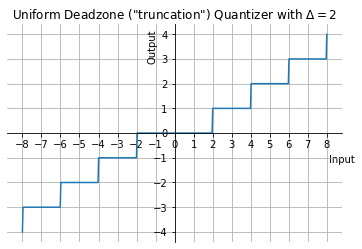

In [645]:
x_plot = np.linspace(-8, 8, 500) # Input samples
y_plot = deadzone_quantizer(x_plot, quantization_step).astype(np.int16)  # Quantized samples
plot_quantizer(x_plot, y_plot, 'Uniform Deadzone ("truncation") Quantizer with $\Delta={}$'.format(quantization_step))

#### Quantization error

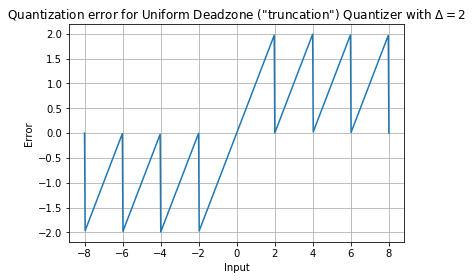

In [646]:
x_plot_recons = y_plot * quantization_step
error_plot = x_plot-x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization error for Uniform Deadzone ("truncation") Quantizer with $\Delta={}$'.format(quantization_step))

#### Compute output for each possible input using 16 bits

In [647]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = deadzone_quantizer(x, quantization_step).astype(np.int16) # Quantized samples

In [648]:
print_center(x, y, 32)

   -16     -8
   -15     -7
   -14     -7
   -13     -6
   -12     -6
   -11     -5
   -10     -5
    -9     -4
    -8     -4
    -7     -3
    -6     -3
    -5     -2
    -4     -2
    -3     -1
    -2     -1
    -1      0
     0      0
     1      0
     2      1
     3      1
     4      2
     5      2
     6      3
     7      3
     8      4
     9      4
    10      5
    11      5
    12      6
    13      6
    14      7
    15      7


In [649]:
len(np.unique(y, return_counts = True)[0])

32768

## B. Companded Quantization

In [908]:
def muLaw_compress(x, mu):
    return np.log(1+mu*np.abs(x))/np.log(1+mu)*np.sign(x)

In [909]:
def muLaw_expand(y, mu):
    return (1/mu)*(((1+mu)**np.abs(y))-1)*np.sign(y)

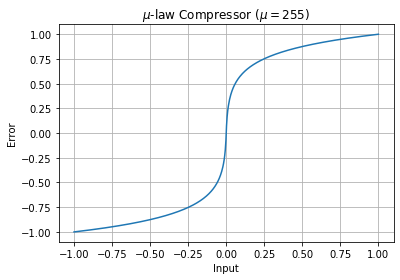

In [929]:
x = np.linspace(-1, 1, 500) # Input samples

mu = 255
y = muLaw_compress(x, mu)
plot_quantization_error(x, y, '$\mu$-law Compressor ($\mu={}$)'.format(mu))

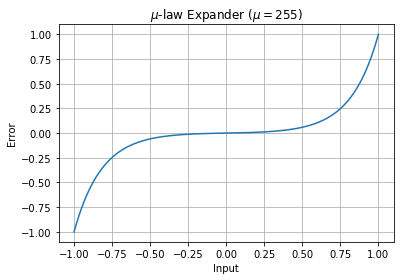

In [930]:
x = np.linspace(-1, 1, 500) # Input samples

mu = 255
y = muLaw_expand(x, mu)
plot_quantization_error(x, y, '$\mu$-law Expander ($\mu={}$)'.format(mu))

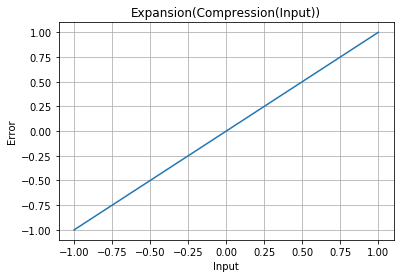

In [912]:
mu = 255
x = np.linspace(-1, 1, 500)
y = muLaw_compress(x, mu)
x_recons = muLaw_expand(y, mu)
plot_quantization_error(x, x_recons, 'Expansion(Compression(Input))'.format(mu))

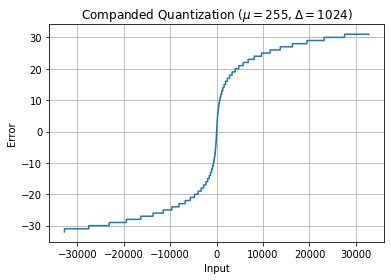

In [933]:
mu = 255
quantization_step = 1024
x = np.linspace(-32768, 32767, 65536)
x_compressed = (32768*(muLaw_compress(x/32768, mu)))
y = deadzone_quantizer(x_compressed, quantization_step).astype(np.int16)
plot_quantization_error(x, y, 'Companded Quantization ($\mu={}, \Delta={}$)'.format(mu, quantization_step))

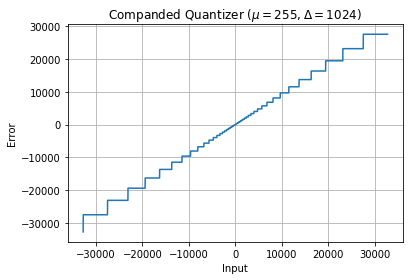

In [934]:
x_compressed_recons = deadzone_dequantizer(y, quantization_step)
x_recons = 32768*muLaw_expand(x_compressed_recons/32768, mu)
plot_quantization_error(x, x_recons, 'Companded Quantizer ($\mu={}, \Delta={}$)'.format(mu, quantization_step))

In [914]:
print(f"{'Input':>6s} {'Output':>6s}")
print_center(x, y, 16)

 Input Output
    -8      0
    -7      0
    -6      0
    -5      0
    -4      0
    -3      0
    -2      0
    -1      0
     0      0
     1      0
     2      0
     3      0
     4      0
     5      0
     6      0
     7      0


In [916]:
y.min()

-32768

#### Quantization error

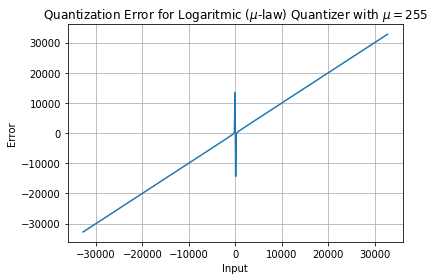

In [858]:
x_plot_recons = (32768*muLaw_dequantizer(y_plot/32768, mu)).astype(np.int16)
error_plot = x_plot - x_plot_recons
plot_quantization_error(x_plot, error_plot, 'Quantization Error for Logaritmic ($\mu$-law) Quantizer with $\mu={}$'.format(mu))

In [859]:
y_plot

array([ -1065,  -1066,  -1067,  -1067,  -1068,  -1069,  -1070,  -1071,
        -1071,  -1072,  -1073,  -1074,  -1075,  -1076,  -1076,  -1077,
        -1078,  -1079,  -1080,  -1081,  -1081,  -1082,  -1083,  -1084,
        -1085,  -1086,  -1087,  -1088,  -1088,  -1089,  -1090,  -1091,
        -1092,  -1093,  -1094,  -1095,  -1096,  -1097,  -1098,  -1099,
        -1100,  -1101,  -1102,  -1103,  -1104,  -1105,  -1106,  -1107,
        -1108,  -1109,  -1110,  -1111,  -1112,  -1113,  -1114,  -1115,
        -1116,  -1117,  -1118,  -1119,  -1121,  -1122,  -1123,  -1124,
        -1125,  -1126,  -1127,  -1129,  -1130,  -1131,  -1132,  -1133,
        -1135,  -1136,  -1137,  -1138,  -1139,  -1141,  -1142,  -1143,
        -1145,  -1146,  -1147,  -1149,  -1150,  -1151,  -1153,  -1154,
        -1155,  -1157,  -1158,  -1160,  -1161,  -1162,  -1164,  -1165,
        -1167,  -1168,  -1170,  -1171,  -1173,  -1175,  -1176,  -1178,
        -1179,  -1181,  -1183,  -1184,  -1186,  -1188,  -1189,  -1191,
      

#### Compute output for each possible input using 16 bits

In [838]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (32768*muLaw_quantizer(x/32768, mu)).astype(np.int16) # Quantized samples

In [839]:
print(f"{'Input':>6s} {'Output':>6s}")
print_center(x, y, 16)

 Input Output
    -8   7222
    -7 -28813
    -6  21781
    -5  28246
    -4  -9095
    -3 -24377
    -2 -17263
    -1  12590
     0      0
     1 -12590
     2  17263
     3  24377
     4   9095
     5 -28246
     6 -21781
     7  28813


In [840]:
len(np.unique(y, return_counts = True)[0])

41391

In [ ]:
x_plot_recos = (x_max/mu)*((1+mu)**(np.abs(_y)/x_max)-1)*np.sign(_y)

# Which is better?

In [290]:
def compute_average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

In [291]:
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(compute_average_energy(error_signal))

In [292]:
# https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [309]:
def midtread_quantization(quantization_step):
    x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
    y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return x, y, x_recons

In [318]:
def deadzone_quantization(quantization_step):
    x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
    y = (x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return x, y, x_recons

In [340]:
def generate_RD_curve_midtread(x, y, x_recons):
    RD_midtread_points = []
    for i in range(1, 32768, 32):
        x, y, x_recons = midtread_quantization(i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_midtread_points.append((rate, distortion))
    return RD_midtread_points

In [344]:
def generate_RD_curve_deadzone(x, y, x_recons):
    RD_deadzone_points = []
    for i in range(1, 32768, 32):
        x, y, x_recons = deadzone_quantization(i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_deadzone_points.append((rate, distortion))
    return RD_deadzone_points

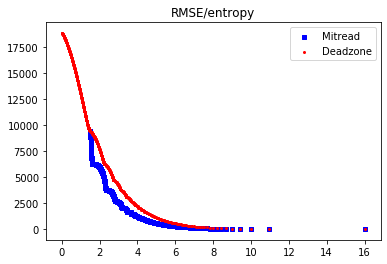

In [345]:
RD_midtread_points = generate_RD_curve_midtread(x, y, x_recons)
RD_deadzone_points = generate_RD_curve_deadzone(x, y, x_recons)
plt.title("RMSE/entropy")
plt.scatter(*zip(*RD_midtread_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*RD_deadzone_points), s=4, c='r', marker="o", label='Deadzone')
plt.legend(loc='upper right')
plt.show()

In [387]:
import sounddevice as sd
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


In [388]:
print(x.max(), x.min())

32767 -32768


In [389]:
sd.play(x)

In [390]:
def _midtread_quantization(x, quantization_step):
    y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return y, x_recons

In [391]:
def _deadzone_quantization(x, quantization_step):
    y = (x/quantization_step).astype(np.int16) # Quantized samples
    x_recons = y*quantization_step # Reconstructed samples
    return y, x_recons

In [392]:
def _generate_RD_curve_midtread(x, y, x_recons):
    RD_midtread_points = []
    for i in range(1, 32768, 32):
        y, x_recons = _midtread_quantization(x, i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_midtread_points.append((rate, distortion))
    return RD_midtread_points

In [393]:
def _generate_RD_curve_deadzone(x, y, x_recons):
    RD_points = []
    for i in range(1, 32768, 32):
        y, x_recons = _deadzone_quantization(x, i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = RMSE(x, x_recons)
        RD_points.append((rate, distortion))
    return RD_points

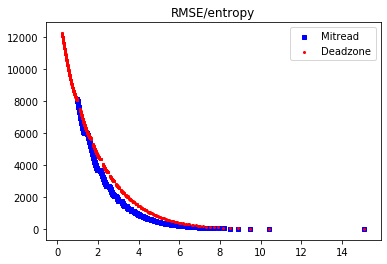

In [394]:
RD_midtread_points = _generate_RD_curve_midtread(x, y, x_recons)
RD_deadzone_points = _generate_RD_curve_deadzone(x, y, x_recons)
plt.title("RMSE/entropy")
plt.scatter(*zip(*RD_midtread_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*RD_deadzone_points), s=4, c='r', marker="o", label='Deadzone')
plt.legend(loc='upper right')
plt.show()

### Rate/Distortion of an Uniform Midtread Quantizer with $\Delta=2$

In [305]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [306]:
rate = entropy_in_bits_per_symbol(y)
distortion = RMSE(x, x_recons)
print("rate =", rate, "bits/sample")
print("distortion =", distortion)
rate/distortion

rate = 7.621980294866581 bits/sample
distortion = 96.05912311205344


0.07934676111893613

### Rate/Distortion of an Uniform Deadzone Quantizer with $\Delta=2$

In [307]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [308]:
rate = entropy_in_bits_per_symbol(y)
distortion = RMSE(x, x_recons)
print("rate =", rate, "bits/sample")
print("distortion =", distortion)
rate/distortion

rate = 7.615864985208631 bits/sample
distortion = 191.49587163633518


0.039770387320264125

### Signal Noise Ratio of an Uniform Deadzone Quantizer with $\Delta=2$

In [267]:
quantization_step = 2
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [268]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 0.5


203.88950309155857

### Signal Noise Ratio of an Uniform Midtread Quantizer with $\Delta=333$

In [269]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = np.round(x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [270]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 9227.35513305664


105.65875393294091

### Signal Noise Ratio of an Uniform Deadzone Quantizer with $\Delta=333$

In [271]:
quantization_step = 333
x = np.linspace(-32768, 32767, 65536).astype(np.int16) # Input samples
y = (x/quantization_step).astype(np.int16) # Quantized samples
x_recons = y*quantization_step # Reconstructed samples

In [272]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 36670.668853759766


91.8607062788887

In [281]:
print(entropy_in_bits_per_symbol(x))

16.0


In [282]:
print(entropy_in_bits_per_symbol(y))

7.615864985208631


In [199]:

def compute_SNR(x, y):
    signal_energy = compute_average_energy(x)
    error_energy = compute_average_energy(x-y)
    print("signal energy =", signal_energy)
    print("error energy =", error_energy)
    return 10*math.log(signal_energy/error_energy)

In [266]:
compute_SNR(x, x_recons)

signal energy = 357913941.5
error energy = 0.5


203.88950309155857

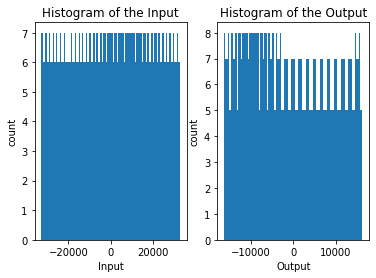

In [117]:
plot_histograms(x, y, 10000)

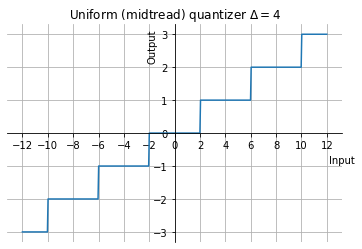

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

quantization_step = 4

fig = plt.figure()
x = np.linspace(-12, 12, 500)
y = np.round(x/quantization_step)

ax = fig.add_subplot(111)
ax.set_title('Uniform (midtread) quantizer $\Delta=4$')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_label_coords(1,0.40)
ax.xaxis.set_label_text('Input')
ax.yaxis.set_label_coords(0.45,.9)
ax.yaxis.set_label_text('Output')

x_ticks = np.arange(-12, 13, 2)
y_ticks = np.arange(-12, 13, 1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.grid()
ax.plot(x, y)

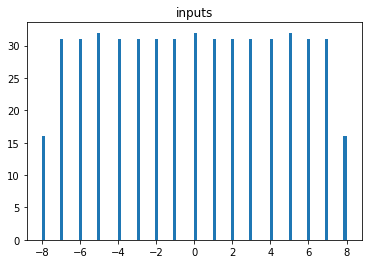

In [32]:
plt.hist(y, bins = 100) 
plt.title("inputs") 
plt.show()

In [73]:
def plot_histograms(x, y, bins):
    fig = plt.figure()

    ax = fig.add_subplot(121)
    ax.hist(x, bins=bins)
    ax.set_title('Histogram of the Input')
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_text('count')

    ax = fig.add_subplot(122)
    ax.hist(y, bins=bins)
    ax.set_title('Histogram of the Output')
    ax.xaxis.set_label_text('Output')
    ax.yaxis.set_label_text('count')

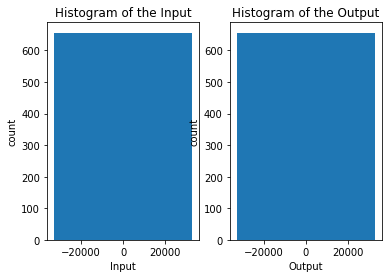

In [74]:
plot_histograms(x, y, bins=100)